# Analyzing Occurrences of and Predictors for Illegal Dumping in Philadelphia


Illegal Dumping differs from littering in its volume and size, typically large objects or construction debris that cannot be picked up by the city's weekly trash collection and require a dumpster for disposal or being brought to a junk yard.

According to a poll conducted by Lenfest Institute for Journalism/SSRS, that surveyed more than 1,200 people about quality of life in Philadelphia in March, 2023, illegal dumping is a concern for a sizeable number of residents. In a question about city services, 60% of poll respondents voted illegal dumping as a major issue and priority for the city, second to fixing road and potholes. There is even pressure on the upcoming mayoral race by multiple community-based advocacy groups to crack down on developers who encourage its practice. Most cases are by small haulers and contractors fromm construction sites. Small haulers can be paid a smaller fee than getting construction debris properly removed and access to proper disposal is either limited to them or expensive.

Illegal dumping disproportionately affects lower-income Latine and Black-majority neighborhoods. According to Klusener's Inquirer article, 70% of Latine and Black respondents and those making less than $50,000 per year marked illegal dumping as a top priority. The figure below is from the article. Community activists say that insufficient transparency and language access around trash pick-up and what collectors can pick up.

The issue worsened over Covid. In 2022, over 8,000 tons of litter and illegally dumped debris, defined as debris cleaned up outside of normal trash collection, were collected and $48 million were spent on clean up. Illegal dumping comes with its share of public health concerns. Vacants lots, dim street lighting, and low foot traffic attract illegal dumping, which in turn attracts vermin to residential areas.

#### Data Sources

The illegal dumping data comes from Philadelphia's 311 API, which contains records of all 311 requests from December 8, 2014 to present and updates data daily. Each request is represented as a point with latitude and longitude coordinates. Given the discussion in the articles, I chose to include demographic data from the Census API and construction permit data from the city's Licenses & Inspections API. I chose to only include data from 01/01/2020 to present since the amount of illegal dumpings increased during Covid-19.

Census data is pulled from two surveys, all at the census tract level.
First, population and racial data from the 2020 Decennial Census. Since the article pointed out Latine and Black majority communities, the fields included are: total population, Hispanic or Latine Only, non-Hispanic or Latine Black/African-American only, non-Hispanic or Latine White only, and non-Hispanic or Latine Asian only. I also calculated a field for People of Color since the Lenfest Institute's survey shows white respondents are least concerned with the issue.
Second, income and English language proficiency data are pulled from the 2020 American Community Survey 5-year estimates. For income, I pulled median income and household annual income brackets below $ 50,000. In order to create a field for income under 50,000 USD, I added the raw counts for 'no income,' 'under 10,000 USD,' '10,000-15,000 USD,' '15,000-25,000 USD,' '25,000-35,000 USD,' and '35,000-50,000 USD.' The census offers two fields to indicate English language proficiency: 'Spanish speakers who speak English less than very well' and 'Other language speakers who speak English less than very well'. I ultimately chose to include both, even though Latine community are among the hardest affected, in case non-Hispanic immigrant communities are also impacted by illegal dumping.

As with the 311 data, License & Inspection (L&I) data is represented as point data and is filtered from 01/01/2020 to present. Given the artciles' emphasis on the role of construction and small haulers, I also filtered the data by permits issued for new construction and by permits whose applicants are contractors. This could present a gap in the data since it might not include renovations and extensions on residential properties.

I ran the analyses both with raw count and normalized data. I normalized by population, dividing demographic and income fields by total population. I also divided the number of new construction permits by population. Although I probably should have divided by total households, using population will point to areas with high concentrations of new construction, such as gentrifying neighborhoods. I also calculated a field for population density (km squared) by dividing total population by land area since a higher number of people might produce more trash and indicate residential areas.

The data collection, spatial join between point data and census tract polygons, and grouping of points by census tract are performed in the jupyter notebooks: census_api.ipynb, lni_api.ipynb, and 311_api.ipynb. Census data does not requite performing a spatial join and grouping by GEOID since it is already by census tract. The merging of all the collected data into one final GeoDataFrame is performed in this notebook below.

A correlation analysis and Random Forest Regression analysis are at the end of this workbook. The Random Forest Regression analysis below is more for testing and uses all the data from 2020 to present. I chose a regression analysis instead of a classification analysis because the response variable, illegal dumping, is continuous. Using both raw and normalized counts, the accuracy of the model is 89% for the raw counts and 90% for normalized data. From what I read online, Random Forest can accept raw counts. Normalizing the data, though, shows predictors' importance are ordered differently and sheds more light on the data.

The notebook, random forest.ipynb, contains a more proper Random Forest analysis. The data is split by date into training/testing data (01/01/2020 to 12/31/2020) and data to use for predictions (01/01/2021 to present).

### In this notebook, I join the data I pulled and cleaned from the APIs and look for any correlations to illegal dumping

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

###### Load data

In [40]:
#tracts
tracts = gpd.read_file("output/tracts.gpkg")
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,count,status,geometry
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,446,"POLYGON ((2677269.006 227883.043, 2677559.538 ..."
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,12,"POLYGON ((2677269.006 227883.043, 2677559.538 ..."
2,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,21,21,"POLYGON ((2681586.156 229114.531, 2681662.861 ..."
3,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,46,46,"POLYGON ((2680111.595 225844.686, 2680393.281 ..."
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,51,50,"POLYGON ((2682331.858 228686.312, 2682639.371 ..."


In [41]:
#census
census = gpd.read_file("output/census_data.gpkg")
census.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,lang_other,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,geometry
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0,"POLYGON ((-75.22235 39.93105, -75.22129 39.931..."
1,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-75.20684 39.93409, -75.20655 39.934..."
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,...,0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,"POLYGON ((-75.21243 39.92523, -75.21130 39.928..."
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,...,0,0.333333,0.000000,0.500000,0.000000,1.000000,0.000000,0.0,0.0,"POLYGON ((-75.20422 39.93285, -75.20305 39.934..."
4,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-75.21612 39.90964, -75.21454 39.910..."


In [42]:
#load L&I data
lni_data = gpd.read_file("output/lni_data.gpkg")
lni_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,count,status,cnt_constr,cnt_contra,geometry
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,446,454,456,"POLYGON ((2677269.006 227883.043, 2677559.538 ..."
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,12,454,456,"POLYGON ((2677269.006 227883.043, 2677559.538 ..."
2,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,21,21,12,12,"POLYGON ((2681586.156 229114.531, 2681662.861 ..."
3,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,46,46,21,21,"POLYGON ((2680111.595 225844.686, 2680393.281 ..."
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,51,50,98,98,"POLYGON ((2682331.858 228686.312, 2682639.371 ..."


In [43]:
census.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'NAME',
       'tot_pop', 'hispLat_pop', 'white_pop', 'black_pop', 'asian_pop',
       'state', 'county', 'tract', 'poc_pop', 'med_inc', 'under_50k',
       'lang_sp', 'lang_other', 'hispLat_pop_pct', 'white_pop_pct',
       'black_pop_pct', 'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct',
       'lang_sp_pct', 'lang_other_pct', 'geometry'],
      dtype='object')

###### Merge count of illegal dumpings to census data

In [44]:
data_merged = tracts.merge(census[['GEOID', 'tot_pop', 'hispLat_pop', 'white_pop', 'black_pop', 'asian_pop','poc_pop','med_inc',
                                   'under_50k', 'lang_sp', 'lang_other', 'hispLat_pop_pct', 'white_pop_pct','black_pop_pct',
                                   'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct','lang_sp_pct', 'lang_other_pct']],
                                   on='GEOID').merge(lni_data[['GEOID', 'cnt_constr', 'cnt_contra']], on='GEOID')
data_merged = data_merged.rename(columns= {'count': 'dump_count'})
data_merged.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,hispLat_pop_pct,white_pop_pct,black_pop_pct,asian_pop_pct,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,cnt_constr,cnt_contra
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0,454,456
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0,454,456
2,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0,454,456
3,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.042297,0.024447,0.879705,0.004657,0.975553,0.891347,0.0,0.0,454,456
4,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,12


In [45]:
data_merged.columns
#len(data_merged)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'dump_count',
       'status', 'geometry', 'tot_pop', 'hispLat_pop', 'white_pop',
       'black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k', 'lang_sp',
       'lang_other', 'hispLat_pop_pct', 'white_pop_pct', 'black_pop_pct',
       'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct', 'lang_sp_pct',
       'lang_other_pct', 'cnt_constr', 'cnt_contra'],
      dtype='object')

###### Normalize L&I data by population

In [60]:
data_merged['cnt_const_pct'] = data_merged['cnt_constr']/data_merged['tot_pop']
data_merged['dump_pct'] = data_merged['dump_count']/data_merged['tot_pop']
data_merged['cnt_contra_pct'] = data_merged['cnt_contra']/data_merged['tot_pop']
data_merged['pop_den'] = data_merged['tot_pop']/(data_merged['ALAND']/1000000) #ALAND is land area in m^2

data_merged

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,poc_pop_pct,under_50k_pct,lang_sp_pct,lang_other_pct,cnt_constr,cnt_contra,cnt_const_pct,cnt_contra_pct,pop_den,dump_pct
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,454,456,0.176174,0.176950,2301.305859,0.177726
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,454,456,0.176174,0.176950,2301.305859,0.177726
2,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,454,456,0.176174,0.176950,2301.305859,0.177726
3,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,...,0.975553,0.891347,0.000000,0.000000,454,456,0.176174,0.176950,2301.305859,0.177726
4,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,...,NaN,NaN,NaN,NaN,12,12,inf,inf,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,...,0.204908,0.294713,0.030357,0.018973,3920,3920,0.991652,0.991652,12068.202287,0.111308
1300,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.180647,0.486410,0.019681,0.013590,4458,4458,1.044517,1.044517,11608.077786,0.125586
1301,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.180647,0.486410,0.019681,0.013590,4458,4458,1.044517,1.044517,11608.077786,0.125586
1302,42,101,002702,42101002702,27.02,Census Tract 27.02,G5020,S,367675,0,...,0.180647,0.486410,0.019681,0.013590,4458,4458,1.044517,1.044517,11608.077786,0.125586


In [62]:
# Compute correlation matrix between all numeric columns
corr_matrix = data_merged[['dump_count', 'dump_pct', 'tot_pop', 'hispLat_pop', 'white_pop',
                           'black_pop', 'asian_pop', 'poc_pop', 'med_inc', 'under_50k', 'lang_sp',
                           'lang_other', 'hispLat_pop_pct', 'white_pop_pct', 'black_pop_pct',
                           'asian_pop_pct', 'poc_pop_pct', 'under_50k_pct', 'lang_sp_pct',
                           'lang_other_pct', 'cnt_constr', 'cnt_contra', 'pop_den']].corr()

# Print correlation matrix
print(corr_matrix)

                 dump_count  dump_pct   tot_pop  hispLat_pop  white_pop  \
dump_count         1.000000 -0.074214  0.216832     0.268178  -0.141207   
dump_pct          -0.074214  1.000000 -0.277278    -0.077747  -0.122505   
tot_pop            0.216832 -0.277278  1.000000     0.447552   0.383674   
hispLat_pop        0.268178 -0.077747  0.447552     1.000000  -0.061688   
white_pop         -0.141207 -0.122505  0.383674    -0.061688   1.000000   
black_pop          0.226004 -0.120645  0.358454    -0.089832  -0.542314   
asian_pop         -0.047405 -0.093097  0.470705     0.168550   0.379063   
poc_pop            0.325115 -0.181461  0.708358     0.495428  -0.380055   
med_inc            0.165707 -0.631516  0.412927     0.130159   0.189956   
under_50k          0.217696 -0.231403  0.892393     0.500805   0.077906   
lang_sp            0.257568 -0.053949  0.312131     0.913406  -0.143772   
lang_other        -0.103285 -0.079708  0.482740     0.202282   0.327371   
hispLat_pop_pct    0.1985

### The variables with the highest correlation with illegal dumping, for raw data, are:
     New Construction
     Population of POC
     Hispanic or Latinx Population
     Spanish speakers who self-identified as "less than very well"
     Black/African American Population
     Population with Income below 50,000$

### The variables with the highest correlation with illegal dumping, for normalized data, are:
     New Construction %
     Population of POC %
     Population of White Only %
     Spanish speakers who self-identified as "less than very well" %
     Population Density by sqaured kilometers %
     Hispanic or Latinx Population %
     Black/African American Population %
     Non-Spanish ESL speakers who self-identified as "less than very well" %

In [48]:
#highest correlations (raw counts)
corr_matrix = data_merged[['dump_count', 'cnt_constr', 'poc_pop', 'hispLat_pop', 'lang_sp', 'black_pop','under_50k']].corr()

# plot correlation matrix
#plt.matshow(corr_matrix)
#plt.show()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,dump_count,cnt_constr,poc_pop,hispLat_pop,lang_sp,black_pop,under_50k
dump_count,nan,nan,nan,nan,nan,nan,nan
cnt_constr,0.40,nan,nan,nan,nan,nan,nan
poc_pop,0.33,-0.12,nan,nan,nan,nan,nan
hispLat_pop,0.27,-0.11,0.50,nan,nan,nan,nan
lang_sp,0.26,-0.11,0.42,0.91,nan,nan,nan
black_pop,0.23,-0.11,0.77,-0.09,-0.09,nan,nan
under_50k,0.22,-0.05,0.83,0.50,0.40,0.51,nan


These results match up with what the articles say. There is a high positive correlation between new construction permits and areas with a high number of People of Color, Latine population, native Spanish speakers, Black/African-American population, and population with annual income below $50,000.

In [63]:
#highest correlations (percentages)
corr_matrix = data_merged[['dump_count', 'cnt_constr', 'poc_pop_pct', 'white_pop_pct', 'lang_sp_pct',
                            'pop_den', 'hispLat_pop_pct', 'black_pop_pct', 'lang_other_pct']].corr()

# plot correlation matrix
#plt.matshow(corr_matrix)
#plt.show()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,dump_count,cnt_constr,poc_pop_pct,white_pop_pct,lang_sp_pct,pop_den,hispLat_pop_pct,black_pop_pct,lang_other_pct
dump_count,nan,nan,nan,nan,nan,nan,nan,nan,nan
cnt_constr,0.40,nan,nan,nan,nan,nan,nan,nan,nan
poc_pop_pct,0.25,-0.33,nan,nan,nan,nan,nan,nan,nan
white_pop_pct,-0.25,0.33,-1.00,nan,nan,nan,nan,nan,nan
lang_sp_pct,0.24,-0.13,0.26,-0.26,nan,nan,nan,nan,nan
pop_den,0.21,0.30,-0.14,0.14,0.08,nan,nan,nan,nan
hispLat_pop_pct,0.20,-0.16,0.26,-0.26,0.87,-0.03,nan,nan,nan
black_pop_pct,0.16,-0.22,0.81,-0.81,-0.22,-0.17,-0.29,nan,nan
lang_other_pct,-0.14,-0.12,-0.13,0.13,0.06,0.11,0.02,-0.31,nan


When we normalize the data, the correlations change a bit. The percentage of new construction permits per capita and the percentae of people of color still have the highest correlations. This time white population appears, but it is the inverse of the field for people of color, so it is repetitive. Interestingly, Spanish-language proficiency has a higher correlation than the percentage of Latine population in a census tract. This suggests that tracts with higher ratios of immigrant population are more vulnerable than those with population that self-identifies as Hispanic or Latine. Population density also has a moderate positive correlation on the number of illegal dumping complaints. Interestingly, the percentage of Black/African-American and non-Hispanic speaking population have a low correlation. It came as quite a surprise that the percentage of population with annual income below 50,000 USD has a correlation close to zero. This suggests that a high presence (count) but not a majority of Black/African-American population and population with income below 50,000 USD is an indicator of vulnerability in a census tract. Demographic indicators where a majority indicates vulnerability are: people of color (or a minority of white people), Spanish proficiency, and population density.

In [65]:
#dumpings per capita, highest correlations (percentages)
corr_matrix = data_merged[['dump_pct', 'med_inc', 'tot_pop', 'under_50k_pct', 'pop_den',
                            'under_50k', 'poc_pop']].corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,dump_pct,med_inc,tot_pop,under_50k_pct,pop_den,under_50k,poc_pop
dump_pct,nan,nan,nan,nan,nan,nan,nan
med_inc,-0.63,nan,nan,nan,nan,nan,nan
tot_pop,-0.28,0.41,nan,nan,nan,nan,nan
under_50k_pct,-0.13,0.17,0.06,nan,nan,nan,nan
pop_den,-0.18,0.27,0.27,-0.16,nan,nan,nan
under_50k,-0.23,0.35,0.89,0.33,0.13,nan,nan
poc_pop,-0.18,0.27,0.71,0.31,0.11,0.83,nan


When we look at the correlations using illegal dumpings per capita, the results are mixed. This is why I chose to keep the raw counts for the correlation above. Here, median income has a very high negative correlation, higher than any of the previous ones. The other correlations that stand out are related to population, but this is because the dumpings per capita values are tied to population. The correlations are very low and close to zero for fields normalized by population.

# Trying out Random Forest Algorithm
### Using only one dataset from 01/01/2020 to present
### Using raw counts

The accuracy is 90%.

In [53]:
#random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define independent and dependent variables
X = data_merged[['cnt_constr', 'poc_pop', 'hispLat_pop', 'lang_sp', 'black_pop','under_50k']]  # independent variables
y = data_merged['dump_count']  # dependent variable

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Test model accuracy
accuracy = rf.score(X_test, y_test)
accuracy

0.9094916826534956

In [54]:
#predict on "new data"
#using the test data  because I am using most up-to-date data
x= pd.DataFrame(X_test)

predict= rf.predict(x)
predict

array([ 667.56,  245.47,  588.52,  463.48,  988.51, 1590.2 ,  535.15,
        975.42,  843.07,  181.66,  558.72,  795.42,   84.37,  379.  ,
        124.92,  588.52,   64.93,  199.52,  638.44,  293.58,  338.5 ,
       1297.62,  238.08,   49.47,  612.16,  821.29,  707.04,  243.67,
       1333.37,  451.98,  826.95,  260.31,  680.48,  297.44,  648.7 ,
        339.83,  462.19,  641.48,  103.85,  452.37,  667.61,  999.8 ,
        256.55,  236.57,  886.94,  303.31,  472.92,   66.74,  246.69,
        667.56, 1270.92,  354.13,   78.59,  463.13,  646.09,  795.42,
        638.44,  978.65, 1071.71,  358.85,  560.07,  859.48,  409.3 ,
       1333.37,   96.69,   66.74,  837.51, 2505.95,  145.68,  782.62,
        181.66,  612.16,  749.93, 1430.08,  244.18,  131.72,  519.12,
        695.96,  698.73, 1417.08,  245.73,  136.73,  150.51,  475.68,
        349.68,  725.11,  239.84,  701.69,  788.58,  325.29,  184.24,
       1237.58,  128.71,  820.92,  261.31,  220.84,  978.65,  131.72,
        421.78,  912

In [55]:
#add predictions to new data
for i in range(len(x)):
    x.loc[i, "preds"] = predict[i]
x

,cnt_constr,poc_pop,hispLat_pop,lang_sp,black_pop,under_50k,preds
1172,2420.0,6792.0,280.0,170.0,6142.0,6065.0,NaN
514,1096.0,2527.0,991.0,211.0,1113.0,2661.0,507.84
843,1910.0,6994.0,5164.0,1364.0,1403.0,5460.0,NaN
977,3290.0,448.0,174.0,0.0,67.0,1130.0,NaN
1168,1762.0,4223.0,196.0,19.0,3775.0,2826.0,NaN
...,...,...,...,...,...,...,...
517,NaN,NaN,NaN,NaN,NaN,NaN,204.36
518,NaN,NaN,NaN,NaN,NaN,NaN,597.95
519,NaN,NaN,NaN,NaN,NaN,NaN,1850.69
520,NaN,NaN,NaN,NaN,NaN,NaN,415.36


In [56]:
#merge to geodataframe
gdf = data_merged.reset_index()
x = x.reset_index()

gdf = gdf.merge(x, on='index')
gdf.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,cnt_const_pct,cnt_contra_pct,pop_den,cnt_constr_y,poc_pop_y,hispLat_pop_y,lang_sp_y,black_pop_y,under_50k_y,preds
0,0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,...,0.176174,0.17695,2301.305859,NaN,NaN,NaN,NaN,NaN,NaN,667.56
1,1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,...,0.176174,0.17695,2301.305859,NaN,NaN,NaN,NaN,NaN,NaN,245.47
2,2,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,...,0.176174,0.17695,2301.305859,454.0,2514.0,109.0,0.0,2267.0,2297.0,588.52
3,3,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,...,0.176174,0.17695,2301.305859,454.0,2514.0,109.0,0.0,2267.0,2297.0,463.48
4,4,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,...,inf,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,988.51


<AxesSubplot: >

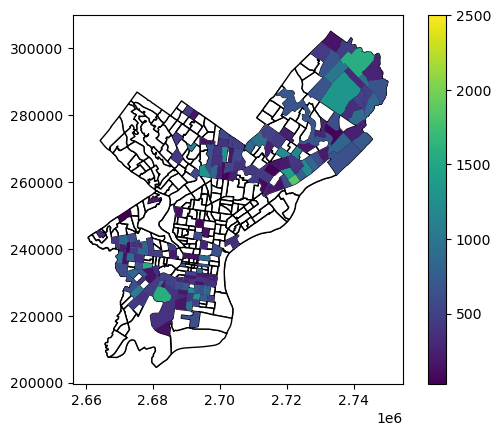

In [57]:
#plot
ax = tracts.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, column='preds', legend=True)

<AxesSubplot: >

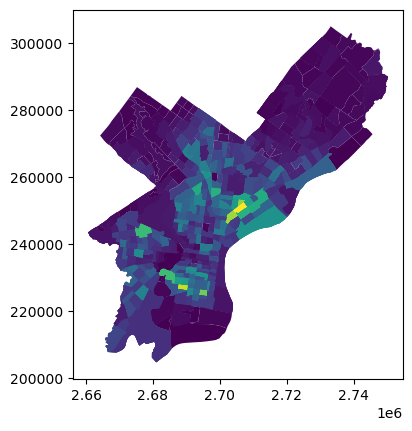

In [58]:
#original plot
data_merged.plot(column='dump_count')

## I decided to split the data I had already gotten into 2020 and 2021-present to try to do a proper Random Forest prediction
#### That can be found in random forest.ipynb

# Sources

Hazelton, Lynette, and Valerie Russ. “Everyone in Philly Knows Illegal Dumping Is a Problem. but for Many Black, Brown, and Low-Income Residents, It's a Crisis.” Https://Www.inquirer.com, The Philadelphia Inquirer, 29 Mar. 2023, https://www.inquirer.com/news/lenfest-institute-for-journalism-ssrs-poll-illegal-dumping-top-priority-black-latino-low-income-20230329.html#:~:text=It%20took%20decades%20for%20the,has%20decreased%20since%20the%20pandemic. 

Schmidt, Sophia. “Groups Challenge Philly's next Mayor: End Illegal Dumping by 2028.” WHYY, WHYY, 1 Feb. 2023, https://whyy.org/articles/waste-free-philly-illegal-dumping-philadelphia-mayoral-race-2023/. 